# Spam Vs Notspam detection complete project:)

## Import libraries

In [1]:
from os import walk
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup


%matplotlib inline

## Email body extraction

In [2]:
with open('data/practice_email.txt') as file:
    msg = file.read()
    
print(msg)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [3]:
# we use this part of the program to open just the message part of the emails

message = open('data/practice_email.txt')

is_body = False
lines = []

for line in message:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

message.close()
        
email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

In [4]:
def email_body_generator(path):
        
        for root, dirnames, filenames in walk(path):
            for file_name in filenames:
                
                filepath = join(root,file_name)
                
                stream = open(filepath, encoding='latin-1')

                is_body = False
                lines = []

                for line in stream:
                    if is_body:
                        lines.append(line)
                    elif line == '\n':
                        is_body = True
                
                stream.close()

                email_body = '\n'.join(lines)
                
                yield email_body 
                

In [5]:
def df_from_directory(path, classification):
    
    rows = []
    
    for email_body in email_body_generator(path):
        rows.append({'MSG': email_body, 'CATEGORY': classification})
        
    return pd.DataFrame(rows)

In [6]:
SPAM_CAT = 1
HAM_CAT = 0

In [7]:
spam_emails = df_from_directory('data/spam_1', SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory('data/spam_2', SPAM_CAT))
print(spam_emails.shape)
spam_emails.head()

(1898, 2)


,MSG,CATEGORY
0,This is a multi-part message in MIME format.\n...,1
1,Lowest rates available for term life insurance...,1
2,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
3,This is a multi-part message in MIME format.\n...,1
4,INVESTMENT SCHOLARS CLUB- bringing you the lat...,1


In [8]:
ham_emails = df_from_directory('data/easy_ham_1',HAM_CAT)
ham_emails = ham_emails.append(df_from_directory('data/easy_ham_2', HAM_CAT))
print(ham_emails.shape)
ham_emails.head()

(3901, 2)


,MSG,CATEGORY
0,URL: e59c6ca5938fc27a6995e30fc10b6482\n\nDate:...,0
1,-----BEGIN PGP SIGNED MESSAGE-----\n\nHash: SH...,0
2,"""Groove really has people running scared""\n\n\...",0
3,URL: http://boingboing.net/#85524596\n\nDate: ...,0
4,"On 07 September 2002, Guido van Rossum said:\n...",0


In [9]:
data = pd.concat([spam_emails, ham_emails], ignore_index=True)
print(data.shape)
data.head()

(5799, 2)


,MSG,CATEGORY
0,This is a multi-part message in MIME format.\n...,1
1,Lowest rates available for term life insurance...,1
2,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
3,This is a multi-part message in MIME format.\n...,1
4,INVESTMENT SCHOLARS CLUB- bringing you the lat...,1


In [10]:
data.index.name = 'DOC_ID'

In [11]:
data.tail()

,MSG,CATEGORY
DOC_ID,,
5794,I just want to say - RAZOR v2 ROCKS! Under Ra...,0
5795,"On Fri, 2002-07-26 at 11:50, Ian Andrew Bell w...",0
5796,"On Mon, 19 Aug 2002 12:01:02 BST, Adrian Murph...",0
5797,"> Special Bonus with your order, you will rece...",0
5798,"On Sat, Jul 20, 2002 at 07:03:17PM +0100, kevi...",0


## Cleaning the dataset

In [12]:
# check if any msg bodies are null
data['MSG'].isnull().values.any()

False

In [13]:
data.isnull().sum()

MSG         0
CATEGORY    0
dtype: int64

In [14]:
# check if there are empty emails 
(data.MSG.str.len() == 0).any()

True

In [15]:
# check the number of empty emails
(data.MSG.str.len() == 0).sum()

3

In [16]:
data[data.MSG.str.len() == 0].index

Int64Index([321, 1358, 3440], dtype='int64', name='DOC_ID')

In [17]:
data.drop([321,1358,3440],inplace=True)

In [18]:
(data.MSG.str.len() == 0).sum()

0

## Display the number of spam and ham using pie chart

In [19]:
amount_ham = data.CATEGORY.value_counts()[0]
amount_spam = data.CATEGORY.value_counts()[1]

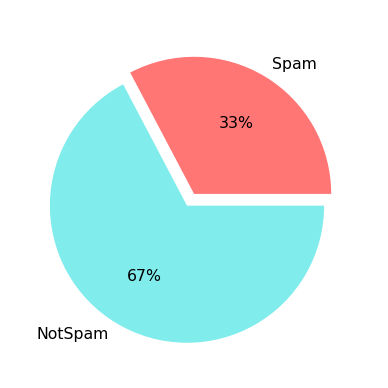

In [20]:
category_name = ['Spam', 'NotSpam']
sizes = [amount_spam ,amount_ham]
custom_color = ['#ff7675', '#81ecec'] 


plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_name,textprops={'fontsize': 5},autopct='%1.0f%%',
                                colors = custom_color, explode = [0, 0.1])
plt.show()

# Nutrual language processing
<p>NLP: use to create systems like speech recognition , document summarization, machine translation, spam detection, question answering, auto completion and so on.</p>

## Text Pre-Processing

<ul>
    <li>Converting to lower case</li>
    <li>Tokenising</li>
    <li>Removing stop words</li>
    <li>Words stemming</li>
    <li>Removing punctuation</li>  
    <li>Stripping out html tags</li>
    
</ul>

### Download The NLTK Resources(Tokenizer and Stopwords)
#### NLTK(Natural Language Toolkit)

In [21]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/programmer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/programmer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### function for cleaning our emails body:
<ol>
    <li>Converting to lower case</li>
    <li>Tokenising</li>
    <li>Removing stop words</li>
    <li>Words stemming</li>
    <li>Removing punctuation</li>  
    <li>Stripping out html tags</li>
    
</ol>
    

In [23]:
def clean_msg(msg, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    # remove html tags
    soup = BeautifulSoup(msg, 'html.parser')
    clean_text = soup.get_text()
    
    # convert to lower case and splits up the words
    words = word_tokenize(clean_text.lower())
    
    filter_words = []
    
    for word in words:
        # removing the stop words and punctuation 
        if word not in stop_words and word.isalpha():
            filter_words.append(stemmer.stem(word)) # words stemming
    
    return ' '.join(filter_words)

In [24]:
clean_data = data
clean_data.head()

,MSG,CATEGORY
DOC_ID,,
0,This is a multi-part message in MIME format.\n...,1
1,Lowest rates available for term life insurance...,1
2,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
3,This is a multi-part message in MIME format.\n...,1
4,INVESTMENT SCHOLARS CLUB- bringing you the lat...,1


In [25]:
%%time 

 clean_data['MSG']= clean_data.MSG.apply(clean_msg)

/home/programmer/.local/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 58.1 s, sys: 70.7 ms, total: 58.1 s
Wall time: 58.4 s


In [26]:
print(clean_data.shape)
clean_data.head()


(5796, 2)


,MSG,CATEGORY
DOC_ID,,
0,messag mime format financi power depend compet...,1
1,lowest rate avail term life insur take moment ...,1
2,beauti custom websit complet beauti custom web...,1
3,messag mime format tba doctor walk walk diabet...,1
4,invest scholar bring latest financi epicent re...,1


## Convert a collection of raw documents to a matrix of TF-IDF features.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer()
feature = clean_data.MSG.values
labels = clean_data['CATEGORY'].values

In [28]:
new_feature = tf.fit_transform(feature)

In [29]:
# TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.
new_feature = new_feature.toarray()

In [30]:
new_feature

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Split data into training and test

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_feature,labels, test_size=0.2, random_state=42)

In [32]:
y_test[:20]

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [33]:
print(X_train.shape)
X_test.shape

(4636, 27300)


(1160, 27300)

## Trian the model

In [34]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,y_train)

GaussianNB()

In [35]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
accuracy_score(y_test,y_pred)

0.9120689655172414

## Application for testing whethere msg is spam or ham

In [36]:
def check_msg(msg):
    
    cleaned_msg = clean_msg(msg)
    
    tf_msg = tf.transform([cleaned_msg])
    
    prediction = model.predict(tf_msg.toarray())
    
    if prediction == 0:
        print('message is ham')
    else:
        print('message is spam')

In [37]:
msg_ham = ham_emails.MSG.iloc[1400]
check_msg(msg_ham)

message is ham


In [38]:
msg_spam = spam_emails.MSG.iloc[200]
check_msg(msg_spam)

message is spam


In [39]:
msg = '''
welcome You won the lottery contect us for more information u won 14000$ cooll
 contact guys!
''' 

In [40]:
check_msg(msg)

message is spam


In [41]:
msg2 = '''
    Thanks for your subscription to Ringtone UK your mobile will be charged $5/month Please confirm by replying YES or NO. If you reply NO you will not be charged
'''

In [42]:
check_msg(msg2)

message is spam


## Using diffrent method for training

In [47]:
from sklearn.naive_bayes import MultinomialNB
model2 = MultinomialNB()
model2.fit(X_train,y_train)

MultinomialNB()

In [48]:
from sklearn.metrics import accuracy_score
y_pred = model2.predict(X_test)
accuracy_score(y_test,y_pred)

0.9534482758620689

### Wow we just use MultinomialNB instead of GuassianNB and got 95% accuracy